# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way Doppler data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging Doppler data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
ref_data = []
sim_meas_data = []
for o in ssn_offsets:
    e = ssn_start + o*u.s
    rv = near_ssn_ref_ephem.rv(e)
    ref_r, ref_rr = ssrMillstone.range_and_rate(rv, e)
    ref_data.append(ref_r)
    sim_meas_data.append(ref_r + ref_rr*ref_r/const.c)

print(ref_data)
print(sim_meas_data)

[<Quantity 35326.33177091 km>, <Quantity 34872.18322202 km>, <Quantity 34417.68557025 km>, <Quantity 33962.83812059 km>, <Quantity 33507.64058431 km>, <Quantity 33052.0931263 km>, <Quantity 32596.19641769 km>, <Quantity 32139.9516941 km>, <Quantity 31683.36082058 km>, <Quantity 31226.42636366 km>, <Quantity 30769.15167164 km>, <Quantity 30311.54096403 km>, <Quantity 29853.59943128 km>, <Quantity 29395.3333461 km>, <Quantity 28936.75018793 km>, <Quantity 28477.85878205 km>, <Quantity 28018.66945552 km>, <Quantity 27559.1942119 km>, <Quantity 27099.44692751 km>, <Quantity 26639.44357193 km>, <Quantity 26179.20245623 km>, <Quantity 25718.74451266 km>, <Quantity 25258.09361042 km>, <Quantity 24797.27691233 km>, <Quantity 24336.32527868 km>, <Quantity 23875.27372494 km>, <Quantity 23414.16194132 km>, <Quantity 22953.03488359 km>, <Quantity 22491.9434459 km>, <Quantity 22030.94522832 km>, <Quantity 21570.10541378 km>, <Quantity 21109.49777175 km>, <Quantity 20649.20580894 km>, <Quantity 2018

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, ssrMillstone)
#fitter.set_debug()
fitter.fit_range_data(ssn_offsets, sim_meas_data)
print(fitter.report())

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 42
    # variables        = 6
    chi-square         = 0.01575820
    reduced chi-square = 4.3773e-04
    Akaike info crit   = -319.298701
    Bayesian info crit = -308.872683
##  Warning: uncertainties could not be estimated:
    a:     at initial value
[[Variables]]
    a:    -8494317.03 (init = -8494317)
    ecc:   1.81448430 (init = 1.813359)
    nu:   -1.84932195 (init = -1.850038)
    inc:   1.88401449 (init = 1.884478)
    raan:  1.53918738 (init = 1.540059)
    argp:  2.53101656 (init = 2.533257)

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.94607863431622 deg
Eccentricity: 1.8144842970162811
Semilatus rectum: 19471975.366903335 m
Semimajor axix: -8494317.028570922 m
Periapse radius: 6918487.833649013 m , altitude: 540351.2336490136 m

::TRAJECTORY::
Start and end ranges: 32460.400024987895 km 14329.622840231634 km
Start and end radial speeds: -7.678950477693802 km

In [7]:
print(fitter.result.residual)

[ 0.02628536  0.00732062 -0.0072     -0.01777121 -0.02487772 -0.02899234
 -0.03057506 -0.03007022 -0.02790501 -0.02448698 -0.02020178 -0.01541023
 -0.01044612 -0.00561283 -0.00118051  0.00261724  0.00558656  0.0075768
  0.00848365  0.00825253  0.00688131  0.00442301  0.00098755 -0.00325714
 -0.0080857  -0.01321749 -0.01832123 -0.02302343 -0.02692051 -0.02959766
 -0.03065498 -0.02974397 -0.02661718 -0.0211955  -0.01365763 -0.0045591
  0.00501068  0.01322241  0.01723595  0.01284717 -0.0059738  -0.04768418]


In [8]:
sim_goldstone_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(sim_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32460.400024987895 km 14329.622840231634 km
Start and end radial speeds: -7.678950477693802 km / s -6.934659719917669 km / s
Closest: 14329.622840231634 km speed 9.426973291484728 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.3062190055575242 deg


In [9]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)
    sim_rv = sim_goldstone_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    ref_meas_r = ref_r + ref_rr*ref_r/const.c
    sim_r, sim_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_shifts.append((sim_r - ref_meas_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    ref_meas_r = ref_r + ref_rr*ref_r/const.c
    sim_r, sim_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_shifts.append((sim_r - ref_meas_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    ref_meas_r = ref_r + ref_rr*ref_r/const.c
    sim_r, sim_rr = dss25.range_and_rate(sim_rv, e)
    dss25_shifts.append((sim_r - ref_meas_r).to_value(u.m))

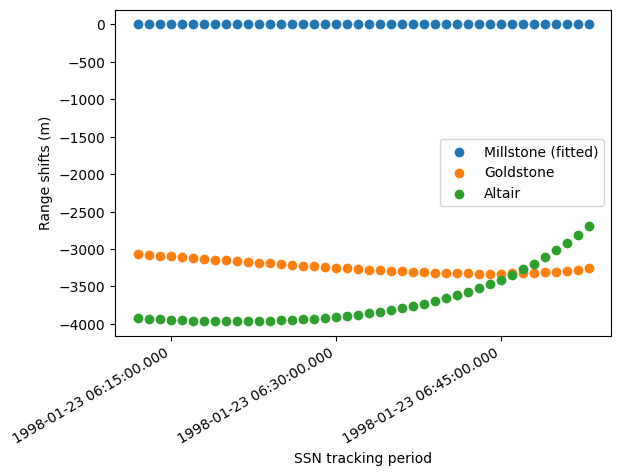

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs, millstone_shifts, label="Millstone (fitted)")
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.scatter(ssn_epochs, altair_shifts, label="Altair")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [11]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)
    sim_rv = sim_goldstone_ephem.rv(e)

    ref_r, ref_rr, ref_ra = ssrAltair.range_rate_accel(ref_rv, e)
    ref_meas_rr = ref_rr + ref_ra*ref_r/const.c
    sim_r, sim_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_doppler.append((sim_rr - ref_meas_rr).to_value(u.m/u.s))

    ref_r, ref_rr, ref_ra = ssrMillstone.range_rate_accel(ref_rv, e)
    ref_meas_rr = ref_rr + ref_ra*ref_r/const.c
    sim_r, sim_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_doppler.append((sim_rr - ref_meas_rr).to_value(u.m/u.s))

    ref_r, ref_rr, ref_ra = dss25.range_rate_accel(ref_rv, e)
    ref_meas_rr = ref_rr + ref_ra*ref_r/const.c
    sim_r, sim_rr = dss25.range_and_rate(sim_rv, e)
    dss25_doppler.append((sim_rr - ref_meas_rr).to_value(u.m/u.s))

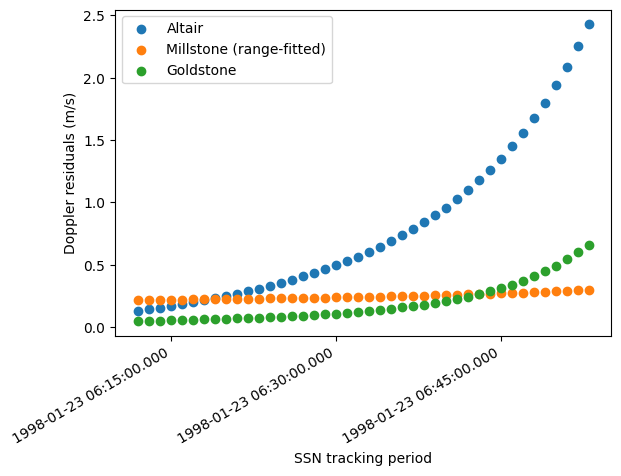

In [12]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs, altair_doppler, label="Altair")
    plt.scatter(ssn_epochs, millstone_doppler, label="Millstone (range-fitted)")
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()